In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np
import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from kmodes.kmodes import KModes
import seaborn as sns
from scipy import stats

In [67]:
def scatter_numerics_vs_price(df, figsize=(15, 15)):
    plt.rcParams["figure.figsize"] = figsize
    to_plot = df.select_dtypes(include=[np.int64, np.float64])
    if len(to_plot.columns) % 3 > 0:
        fig, ax = plt.subplots(int(len(to_plot.columns)/3), 3)
    else:
        fig, ax = plt.subplots(int(len(to_plot.columns)/3), 3)
    
    fig = plt.figure(figsize=(15, 8))
    
    xvars = [x for x in to_plot.columns if x != "Price"]
    xvars_ind = 0
    for i in range(len(ax)):
        for j in range(len(ax[0])):
            ax[i][j].scatter(to_plot[xvars[xvars_ind]], to_plot["Price"])
            ax[i][j].set_xlabel(xvars[xvars_ind])
            xvars_ind += 1
            if xvars_ind == (len(xvars)):
                break
    
    fig.suptitle('All Independents VS Price', fontsize=20)
    plt.show()
            

# Data Import and Preprocessing

First we will import our data as a dataframe using pandas. 

In [3]:
cars = pd.read_csv("../car_price_prediction.csv")
cars

,ID,Price,Levy,Manufacturer,Model,Prod. year,Category,Leather interior,Fuel type,Engine volume,Mileage,Cylinders,Gear box type,Drive wheels,Doors,Wheel,Color,Airbags
0,45654403,13328,1399,LEXUS,RX 450,2010,Jeep,Yes,Hybrid,3.5,186005 km,6.0,Automatic,4x4,04-May,Left wheel,Silver,12
1,44731507,16621,1018,CHEVROLET,Equinox,2011,Jeep,No,Petrol,3,192000 km,6.0,Tiptronic,4x4,04-May,Left wheel,Black,8
2,45774419,8467,-,HONDA,FIT,2006,Hatchback,No,Petrol,1.3,200000 km,4.0,Variator,Front,04-May,Right-hand drive,Black,2
3,45769185,3607,862,FORD,Escape,2011,Jeep,Yes,Hybrid,2.5,168966 km,4.0,Automatic,4x4,04-May,Left wheel,White,0
4,45809263,11726,446,HONDA,FIT,2014,Hatchback,Yes,Petrol,1.3,91901 km,4.0,Automatic,Front,04-May,Left wheel,Silver,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19232,45798355,8467,-,MERCEDES-BENZ,CLK 200,1999,Coupe,Yes,CNG,2.0 Turbo,300000 km,4.0,Manual,Rear,02-Mar,Left wheel,Silver,5
19233,45778856,15681,831,HYUNDAI,Sonata,2011,Sedan,Yes,Petrol,2.4,161600 km,4.0,Tiptronic,Front,04-May,Left wheel,Red,8
19234,45804997,26108,836,HYUNDAI,Tucson,2010,Jeep,Yes,Diesel,2,116365 km,4.0,Automatic,Front,04-May,Left wheel,Grey,4
19235,45793526,5331,1288,CHEVROLET,Captiva,2007,Jeep,Yes,Diesel,2,51258 km,4.0,Automatic,Front,04-May,Left wheel,Black,4


## Preprocessing

First we will check to see if any null values are present. 

In [4]:
# Check if the dataset contains NaN/null values
cars.isnull().values.any()

False

Great, none of the numerical columns that were read in contained null values. 

Lets look at the types of each of our dataframe columns. 

In [5]:
cars.dtypes

ID                    int64
Price                 int64
Levy                 object
Manufacturer         object
Model                object
Prod. year            int64
Category             object
Leather interior     object
Fuel type            object
Engine volume        object
Mileage              object
Cylinders           float64
Gear box type        object
Drive wheels         object
Doors                object
Wheel                object
Color                object
Airbags               int64
dtype: object

Lets clean any misentry values in the price column. 

In [6]:
# Check price for outliers by z-test and look for vals greater than 3 standard deviations
# from mean
price_outliers = cars[(np.abs(stats.zscore(cars["Price"])) >= 3)]
price_outliers

,ID,Price,Levy,Manufacturer,Model,Prod. year,Category,Leather interior,Fuel type,Engine volume,Mileage,Cylinders,Gear box type,Drive wheels,Doors,Wheel,Color,Airbags
1225,45795524,627220,-,MERCEDES-BENZ,G 65 AMG 63AMG,2020,Jeep,Yes,Petrol,6.3 Turbo,0 km,8.0,Tiptronic,4x4,04-May,Left wheel,Black,12
8541,45761204,872946,2067,LAMBORGHINI,Urus,2019,Universal,Yes,Petrol,4,2531 km,8.0,Tiptronic,4x4,04-May,Left wheel,Black,0
16983,45812886,26307500,-,OPEL,Combo,1999,Goods wagon,No,Diesel,1.7,99999 km,4.0,Manual,Front,02-Mar,Left wheel,Blue,0


From the above Z-Score test we can see that we have three outliers. From market research, we have some prices for these cars:

* 2019 Lamborghini Urus: 221,000 Dollars
* 2020 Mercedes-Benz G65 AMG: 200,000 Dollars
* 1999 Opel Combo: 900 Dollars 

From this, we can see that the prices on all three of these records is significantly higher than what the cars are actually going for on the market. Thus, we are going to classify these invalid entries and remove them. The following code will remove these values

In [8]:
cars = cars.drop(16983)
cars = cars.drop(8541)
cars = cars.drop(1225)

cars.reset_index(inplace=True, drop=True)

### Handling non-numeric columns

This dataset contains a significant amount of non-numeric data. We need to convert this data to a numerical format for analysis:

**Column: Levy**

The levy column contains numeric values. However, it was loaded as a string column due to the fact that in cases where a levy was not placed on the vehicle, a "-" character is present. To handle this column, we will cast all string numbers to floats and fill "-"s' with zeros as in these cases there was a $0 levy present.   

In [ ]:
# Handle Levy
ln = []
for i in cars["Levy"]:
    try:
        ln += [int(i)]
    except:
        ln += [np.NaN]

nplm = np.array(ln)    
nplm = np.nan_to_num(nplm)
cars["Levy_Numeric"] = nplm

**Column: Leather Interior**

This column two catagories; "Yes" if a car has a leather interior, and "No" if a car does not contain a leather interior. We will replace "Yes" with one and "No" with zero. 

In [ ]:
# Handle leather interior
leather_unique = list(set(cars["Leather interior"]))   # Get all unique drive category
cars["Leather_Interior_Numeric"] = [leather_unique.index(x) for x in cars["Leather interior"]]

**Column: Mileage**

This column describes the mileage on the car at the time of sale. The values are numeric however they were loaded in as strings due to there being units present. To handle this column, we will remove the units and cast the values to integer form. 

In [ ]:
# Handle mileage
cars["Mileage_Numeric"] = [int(x.split(" ")[0]) for x in cars["Mileage"]]

**Column: Wheele**

This column describes whether the wheel is on the left hand or right hand side. There are only two values present so, we will convert this to a binary column just as we did with leather interior. 

In [ ]:
# Handle wheel
wheel_unique = list(set(cars["Wheel"]))   # Get all unique Wheels
cars["Wheel_Numeric"] = [wheel_unique.index(x) for x in cars["Wheel"]]

**Column: Engine Volume**

This column describes the volume of the engine in liters. The data is mostly numeric however, some entries contain "turbo" if the cars engine is turbo charged. To handle this column, we will cast the numeric values to floats and create a seperate binary column indecating if the car has a turbo. 

In [ ]:
# Handle engine volume by splitting a column into volume and turbo columns
volume = []
has_turbo = []
for vol in cars["Engine volume"]:
    parts = vol.split(" ")
    volume += [float(parts[0])]   # since these numbers are all small well use 16-bit float to save memory
    if len(parts) > 1:
        has_turbo += [1]
    else:
        has_turbo += [0]

cars["Engine_vol_numeric"] = volume
cars["Has_turbo"] = has_turbo
cars

**Columns: Model and Manufacturer**

These two columns contain the model and manufacturer information of the car being sold. These columns are a bit harder to deal with due to the shear scale of the number of catagories present. To deal with this, we will group each model and manufacturer and take the average price for these pairings. We will then create a new column containing this encoding. 

In [ ]:
# Handle model and manufacturer columns by filling with average price of model-manufacturer combinations
mm_comb = [f"{x} : {y}" for x, y in zip(cars["Manufacturer"], cars["Model"])]
avg_prices = {}
mm_comb_unique = set(mm_comb)

# Set up a dictionary to contain all average prices for models
for i in mm_comb_unique:
    avg_prices[i] = []
 

for i, price in enumerate(cars["Price"]):
    avg_prices[mm_comb[i]] += [price]

# Set values to averages
for comb in avg_prices.keys():
    avg_prices[comb] = np.array(avg_prices[comb]).mean()
    
cars["Average_price_MMC"] = [avg_prices[x] for x in mm_comb]

**Column: Production Year**

This column is already numeric however, we will create an encoding of it for experimental purposes. This encoding will be the distance of the cars production year from the sample median. 

In [ ]:
# Handle prod. year by transforming it to be distance from the median year
med_year = np.median(np.array(cars["Prod. year"]))
cars["Dist_from_med_PY"] = [year - med_year for year in cars["Prod. year"]]

**Column: Doors**
This column describes the number of doors the car posses. The following three categories are present in the data:

* "02-Mar": Car has 2-3 doors
* "04-May": Car has 4-5 doors
* ">5": Car has more than 5 doors

To handle this column, we will convert the entries to the number of doors present in the category label as follows:

* "02-Mar": 2
* "04-May": 4
* ">5": Car 5


In [9]:
# Handle Doors
cars["Doors_numeric"] = [np.uint16(x[1]) for x in cars["Doors"]]
cars

,ID,Price,Levy,Manufacturer,Model,Prod. year,Category,Leather interior,Fuel type,Engine volume,...,Airbags,Levy_Numeric,Leather_Interior_Numeric,Mileage_Numeric,Wheel_Numeric,Engine_vol_numeric,Has_turbo,Average_price_MMC,Dist_from_med_PY,Doors_numeric
0,45654403,13328,1399,LEXUS,RX 450,2010,Jeep,Yes,Hybrid,3.5,...,12,1399.0,1,186005,0,3.5,0,10673.098266,-2.0,4
1,44731507,16621,1018,CHEVROLET,Equinox,2011,Jeep,No,Petrol,3,...,8,1018.0,0,192000,0,3.0,0,8751.652174,-1.0,4
2,45774419,8467,-,HONDA,FIT,2006,Hatchback,No,Petrol,1.3,...,2,0.0,0,200000,1,1.3,0,11088.957399,-6.0,4
3,45769185,3607,862,FORD,Escape,2011,Jeep,Yes,Hybrid,2.5,...,0,862.0,1,168966,0,2.5,0,8159.228188,-1.0,4
4,45809263,11726,446,HONDA,FIT,2014,Hatchback,Yes,Petrol,1.3,...,4,446.0,1,91901,0,1.3,0,11088.957399,2.0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19229,45798355,8467,-,MERCEDES-BENZ,CLK 200,1999,Coupe,Yes,CNG,2.0 Turbo,...,5,0.0,1,300000,0,2.0,1,7564.875000,-13.0,2
19230,45778856,15681,831,HYUNDAI,Sonata,2011,Sedan,Yes,Petrol,2.4,...,8,831.0,1,161600,0,2.4,0,14438.978684,-1.0,4
19231,45804997,26108,836,HYUNDAI,Tucson,2010,Jeep,Yes,Diesel,2,...,4,836.0,1,116365,0,2.0,0,30076.930070,-2.0,4
19232,45793526,5331,1288,CHEVROLET,Captiva,2007,Jeep,Yes,Diesel,2,...,4,1288.0,1,51258,0,2.0,0,17752.692857,-5.0,4


### Createing a dataframe for processing:

First, lets create a copy of our car sales dataframe and drop the uncleaned versions of the columns we have already processed. 

In [ ]:
cars_processed = cars.copy(deep=True)
cars_processed = cars_processed.drop(["Manufacturer"], axis=1)
cars_processed = cars_processed.drop(["Model"], axis=1)
cars_processed = cars_processed.drop(["Levy"], axis=1)
cars_processed = cars_processed.drop(["Leather interior"], axis=1)
cars_processed = cars_processed.drop(["Mileage"], axis=1)
cars_processed = cars_processed.drop(["Wheel"], axis=1)
cars_processed = cars_processed.drop(["Engine volume"], axis=1)
cars_processed.rename(columns={'Prod. year': 'Prod_year', 'Fuel type': 'Fuel_type', 'Gear box type': 'Gear_box_type', 
                     'Drive wheels': 'Drive_wheels'}, inplace=True)

Next, due to the way statsmodels handles regression model formulas, we need to clean our catagorical variables and prepare them for dummy variable creation. This entails removing any characters that arent compatible with formula creawtion like: " ", "-", etc...

In [ ]:
# Clean values in the catagorical variables for use in regression model
cleaned_catags = []
for car in cars_processed["Category"]:
    if car == "Goods wagon":
        cleaned_catags += ["Goods_wagon"]
    else:
        cleaned_catags += [car]
cars_processed["Category"] = cleaned_catags

cleaned_colors = []
for car in cars_processed["Color"]:
    if " " in car:
        cleaned_colors += ["_".join(car.split(" "))]
    else:
        cleaned_colors += [car]
cars_processed["Color"] = cleaned_colors

cleaned_fuel = []
for car in cars_processed["Fuel_type"]:
    if " " in car:
        car = "_".join(car.split(" "))
    if "-" in car:
        car = "_".join(car.split("-"))
    cleaned_fuel += [car]
cars_processed["Fuel_type"] = cleaned_fuel

cleaned_doors = []
for car in cars_processed["Doors"]:
    if car == "02-Mar":
        car = "two_Mar"
    elif car == "04-May":
        car = "five_May"
    else:
        car = "more"
    cleaned_doors += [car]
cars_processed["Doors"] = cleaned_doors

# Cast catagorical variables to uint8 for efficiency
cars_processed["Wheel_Numeric"] = np.array(cars["Wheel_Numeric"], dtype=np.uint8)
#cars["Is_grayscale"] = np.array(cars["Is_grayscale"], dtype=np.uint8)
cars_processed["Leather_Interior_Numeric"] = np.array(cars["Leather_Interior_Numeric"], dtype=np.uint8)
cars_processed["Has_turbo"] = np.array(cars["Has_turbo"], dtype=np.uint8)

cars_processed = cars_processed.drop(["Doors"], axis=1)

Now, we can use a pandas function to create dummy variables for the remaining categorical data. These dummy variables will be binary decisions relating to each category in our categorical columns. 

In [10]:
cars_processed = pd.get_dummies(cars_processed).drop(["ID"], axis=1)
cars_processed

,Price,Prod_year,Cylinders,Airbags,Levy_Numeric,Leather_Interior_Numeric,Mileage_Numeric,Wheel_Numeric,Engine_vol_numeric,Has_turbo,...,Color_Green,Color_Grey,Color_Orange,Color_Pink,Color_Purple,Color_Red,Color_Silver,Color_Sky_blue,Color_White,Color_Yellow
0,13328,2010,6.0,12,1399.0,1,186005,0,3.5,0,...,0,0,0,0,0,0,1,0,0,0
1,16621,2011,6.0,8,1018.0,0,192000,0,3.0,0,...,0,0,0,0,0,0,0,0,0,0
2,8467,2006,4.0,2,0.0,0,200000,1,1.3,0,...,0,0,0,0,0,0,0,0,0,0
3,3607,2011,4.0,0,862.0,1,168966,0,2.5,0,...,0,0,0,0,0,0,0,0,1,0
4,11726,2014,4.0,4,446.0,1,91901,0,1.3,0,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19229,8467,1999,4.0,5,0.0,1,300000,0,2.0,1,...,0,0,0,0,0,0,1,0,0,0
19230,15681,2011,4.0,8,831.0,1,161600,0,2.4,0,...,0,0,0,0,0,1,0,0,0,0
19231,26108,2010,4.0,4,836.0,1,116365,0,2.0,0,...,0,1,0,0,0,0,0,0,0,0
19232,5331,2007,4.0,4,1288.0,1,51258,0,2.0,0,...,0,0,0,0,0,0,0,0,0,0


Lets also try an encoding scheme for the color column. We will create a new column containing a binary indecator which describes a cars color as grayscale (white, silver, black, etc.) or not grayscale (green, blue, orange, etc.). 

In [1]:
grayscale = ["Grey", "Black", "Silver", "White"]
is_grayscale = []
for x in cars["Color"]:
    if x in grayscale:
        is_grayscale += [1]
    else:
        is_grayscale += [0]

cars_processed["Is_grayscale"] = np.array(is_grayscale, dtype=np.uint8)

NameError: name 'cars' is not defined

# Statistical Analysis

### Test Model Fit

Lets start by fitting a test regression model to get a look at which columns are immediately significant and what challenges we should focus on. 

In [12]:
regressors = " + ".join(cars_processed.columns[1:])
equation = f"Price ~ {regressors}"
model = smf.ols(formula=equation,
                data=cars_processed).fit()
  
# model summary
all_model_summary = model.summary()
print(all_model_summary)

                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.529
Model:                            OLS   Adj. R-squared:                  0.527
Method:                 Least Squares   F-statistic:                     457.8
Date:                Thu, 20 Oct 2022   Prob (F-statistic):               0.00
Time:                        16:42:17   Log-Likelihood:            -2.0881e+05
No. Observations:               19234   AIC:                         4.177e+05
Df Residuals:                   19186   BIC:                         4.181e+05
Df Model:                          47                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

### Investigate assumptions

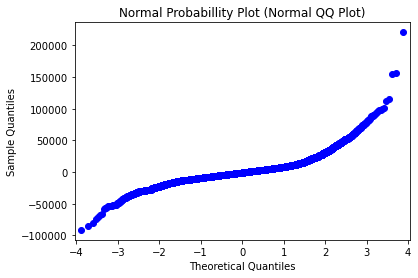

In [13]:
#fig, ax = plt.subplots(1, 2)
sm.qqplot(model.resid)
plt.title("Normal Probabillity Plot (Normal QQ Plot)")
plt.show()

(array([7.0000e+00, 1.9100e+02, 1.2177e+04, 6.4980e+03, 3.0400e+02,
        4.8000e+01, 6.0000e+00, 2.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([-91473.58175882, -60240.28672971, -29006.99170061,   2226.3033285 ,
         33459.59835761,  64692.89338672,  95926.18841582, 127159.48344493,
        158392.77847404, 189626.07350315, 220859.36853225]),
 <a list of 10 Patch objects>)

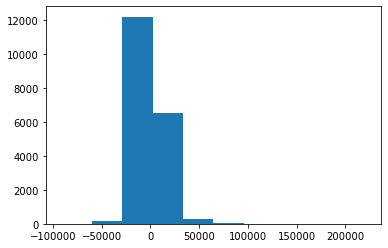

In [14]:
plt.hist(model.resid)

Normallity violated because its not straight

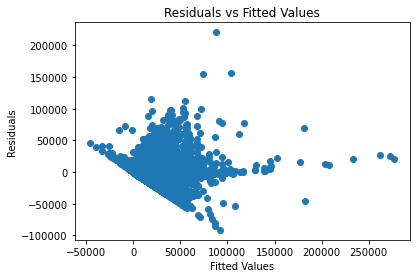

In [15]:
plt.scatter(model.fittedvalues, model.resid)
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.title("Residuals vs Fitted Values")
plt.show()

Assumption violated, non constant variance so heterosedacity is present

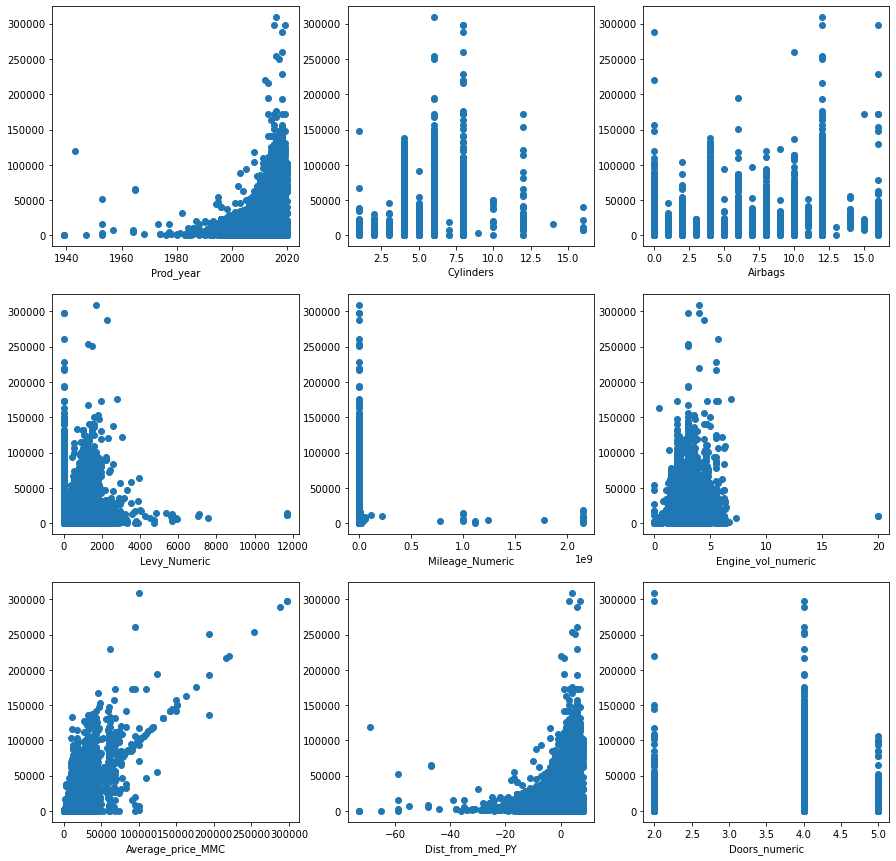

<Figure size 1080x576 with 0 Axes>

In [16]:
scatter_numerics_vs_price(cars_processed)

We notice that not many of the numeric variables have a linear relationship with price. 

We need to apply transformations to ease some issues however first lets remove some insignificant predictors for efficiency. The following code will create a dataframe containing only the variables that proved to be statistically significant in our test model. 

In [17]:
significant_vars = []

# Iterate through the table and find all significant predictors
for i in range(2, len(all_model_summary.tables[1])):
    if float(str(all_model_summary.tables[1][i][4])) < 0.05:
        significant_vars += [str(all_model_summary.tables[1][i][0])]
        
significant_vars

['Prod_year',
 'Airbags',
 'Levy_Numeric',
 'Leather_Interior_Numeric',
 'Wheel_Numeric',
 'Engine_vol_numeric',
 'Has_turbo',
 'Average_price_MMC',
 'Dist_from_med_PY',
 'Doors_numeric',
 'Category_Cabriolet',
 'Category_Goods_wagon',
 'Category_Hatchback',
 'Category_Jeep',
 'Category_Limousine',
 'Category_Microbus',
 'Category_Minivan',
 'Category_Pickup',
 'Category_Sedan',
 'Category_Universal',
 'Fuel_type_Plug_in_Hybrid',
 'Gear_box_type_Automatic',
 'Gear_box_type_Tiptronic',
 'Gear_box_type_Variator',
 'Color_Grey',
 'Color_Orange',
 'Color_Purple',
 'Color_Red',
 'Color_Silver']

In [18]:
significant_vars += ["Price"]  # Add price back into the list
significant_vars_df = cars_processed.copy(deep=True)[significant_vars]   # Create a dataframe with only significant predictors
significant_vars_df

,Prod_year,Airbags,Levy_Numeric,Leather_Interior_Numeric,Wheel_Numeric,Engine_vol_numeric,Has_turbo,Average_price_MMC,Dist_from_med_PY,Doors_numeric,...,Fuel_type_Plug_in_Hybrid,Gear_box_type_Automatic,Gear_box_type_Tiptronic,Gear_box_type_Variator,Color_Grey,Color_Orange,Color_Purple,Color_Red,Color_Silver,Price
0,2010,12,1399.0,1,0,3.5,0,10673.098266,-2.0,4,...,0,1,0,0,0,0,0,0,1,13328
1,2011,8,1018.0,0,0,3.0,0,8751.652174,-1.0,4,...,0,0,1,0,0,0,0,0,0,16621
2,2006,2,0.0,0,1,1.3,0,11088.957399,-6.0,4,...,0,0,0,1,0,0,0,0,0,8467
3,2011,0,862.0,1,0,2.5,0,8159.228188,-1.0,4,...,0,1,0,0,0,0,0,0,0,3607
4,2014,4,446.0,1,0,1.3,0,11088.957399,2.0,4,...,0,1,0,0,0,0,0,0,1,11726
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19229,1999,5,0.0,1,0,2.0,1,7564.875000,-13.0,2,...,0,0,0,0,0,0,0,0,1,8467
19230,2011,8,831.0,1,0,2.4,0,14438.978684,-1.0,4,...,0,0,1,0,0,0,0,1,0,15681
19231,2010,4,836.0,1,0,2.0,0,30076.930070,-2.0,4,...,0,1,0,0,1,0,0,0,0,26108
19232,2007,4,1288.0,1,0,2.0,0,17752.692857,-5.0,4,...,0,1,0,0,0,0,0,0,0,5331


In [19]:
# corr_matrix = significant_vars_df.corr()
# corr_matrix.style.background_gradient(cmap="coolwarm")
vif = pd.DataFrame()
vif["features"] = significant_vars_df.columns
vif["vif_Factor"] = [variance_inflation_factor(significant_vars_df.values, i) for i in range(significant_vars_df.shape[1])]
vif

,features,vif_Factor
0,Prod_year,127.084168
1,Airbags,1.295609
2,Levy_Numeric,1.559173
3,Leather_Interior_Numeric,1.632407
4,Wheel_Numeric,1.374340
5,Engine_vol_numeric,1.650547
6,Has_turbo,1.306954
7,Average_price_MMC,2.053697
8,Dist_from_med_PY,2.193278
9,Doors_numeric,1.618034


We see strong evidence of multi-colinearity among a few of the predictors. 

engine vol 0.123430

## Experimenting with Data Transformations

Before we begin, lets fit a baseline model with only our significant predictors. This will tell us how the model preforms without the insignificant predictors and will serve as a comparison for later models. 

In [20]:
regressors = " + ".join(significant_vars_df.columns[:26])
equation = f"Price ~ {regressors}"
signif_model_res = smf.ols(formula=equation,
                data=significant_vars_df).fit()
  
# model summary
signif_model_summary = signif_model_res.summary()
print(signif_model_summary)

                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.525
Model:                            OLS   Adj. R-squared:                  0.525
Method:                 Least Squares   F-statistic:                     849.8
Date:                Thu, 20 Oct 2022   Prob (F-statistic):               0.00
Time:                        16:42:49   Log-Likelihood:            -2.0888e+05
No. Observations:               19234   AIC:                         4.178e+05
Df Residuals:                   19208   BIC:                         4.180e+05
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

First lets attempt to reduce the number of catagorical variables we have by clustering with K-modes. 

In [21]:
all_colors = [x for x in significant_vars_df.columns if "Color" in x]
all_categs = [x for x in significant_vars_df.columns if "Category" in x]
all_fuels = [x for x in significant_vars_df.columns if "Fuel" in x]
all_gear = [x for x in significant_vars_df.columns if "Gear" in x]

to_cluster_1 = all_categs + all_fuels + all_gear

car_types_1 = significant_vars_df[to_cluster_1]
km = KModes(n_clusters=8, init='Huang', n_init=10, verbose=1)

clusters_1 = km.fit_predict(car_types_1)

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 750, cost: 4259.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 1291, cost: 4562.0
Run 2, iteration: 2/100, moves: 189, cost: 4562.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 1053, cost: 5627.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/100, moves: 998, cost: 4049.0
Run 4, iteration: 2/100, moves: 68, cost: 4049.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 5, iteration: 1/100, moves: 519, cost: 6017.0
Run 5, iteration: 2/100, moves: 0, cost: 6017.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 6, iteration: 1/100, moves: 1044, cost: 6372.0
Init: initializing centroids
Init: initializing clusters
Starting iter

In [22]:
clusters_1

array([0, 7, 6, ..., 0, 0, 3], dtype=uint16)

Lets plot our cluster labels versus car price to see if we notice a relationship between the cluster and price. This should help us determine if this is a good method for condensing our catagorical variables. 

In [23]:
#significant_vars_df["cluster_labels"] = clusters

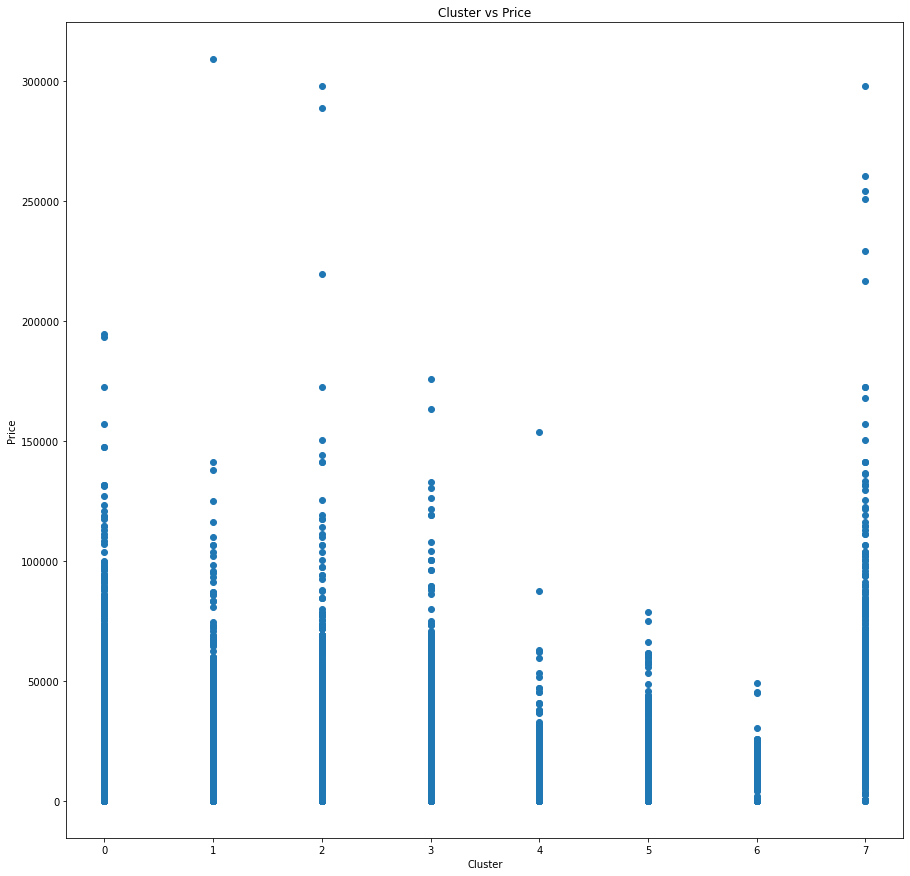

In [24]:
plt.scatter(clusters_1, significant_vars_df["Price"])
plt.xlabel("Cluster")
plt.ylabel("Price")
plt.title("Cluster vs Price")
plt.show()

We can see that the relationship between our clusters and car price is weak. The variance on many of the clusters is way too large. Lets try clustering different varables. Next, we will cluster the car catagories and colors. 

In [25]:
to_cluster_2 = all_categs + all_colors

car_types_2 = significant_vars_df[to_cluster_2]
km = KModes(n_clusters=10, init='Huang', n_init=10, verbose=1)

clusters_2 = km.fit_predict(car_types_2)

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 674, cost: 4681.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 184, cost: 5150.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 0, cost: 3677.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/100, moves: 0, cost: 5577.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 5, iteration: 1/100, moves: 630, cost: 3754.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 6, iteration: 1/100, moves: 321, cost: 4940.0
Run 6, iteration: 2/100, moves: 2, cost: 4940.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 7, iteration: 1/100, moves: 155, cost: 4629.0
Init: initializing centroids
Init: initializin

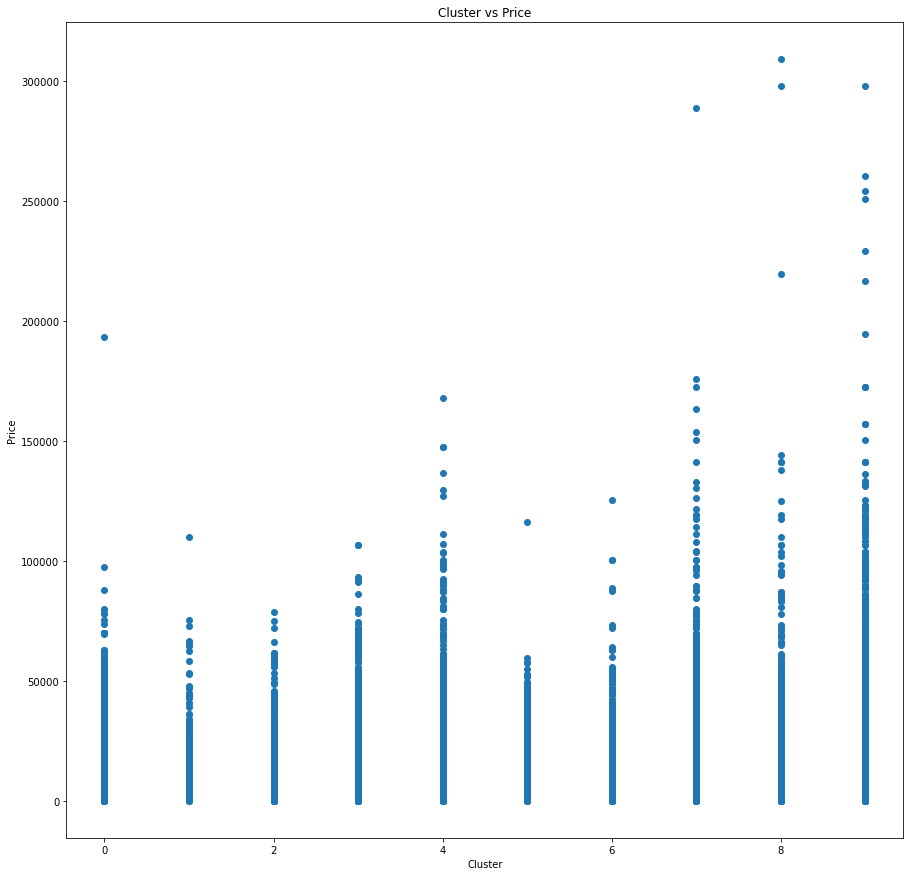

In [26]:
plt.scatter(clusters_2, significant_vars_df["Price"])
plt.xlabel("Cluster")
plt.ylabel("Price")
plt.title("Cluster vs Price")
plt.show()

We seem to be going in the right direction

In [27]:
to_cluster_3 = all_categs + all_gear + all_fuels + all_colors

car_types_3 = significant_vars_df[to_cluster_3]
km = KModes(n_clusters=10, init='Huang', n_init=10, verbose=1)

clusters_3 = km.fit_predict(car_types_3)

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 3069, cost: 8623.0
Run 1, iteration: 2/100, moves: 439, cost: 8623.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 5542, cost: 14739.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 2575, cost: 10893.0
Run 3, iteration: 2/100, moves: 640, cost: 10893.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/100, moves: 1692, cost: 11693.0
Run 4, iteration: 2/100, moves: 13, cost: 11693.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 5, iteration: 1/100, moves: 2601, cost: 11042.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 6, iteration: 1/100, moves: 2881, cost: 9651.0
Run 6, iteration: 2/100, moves: 393, cost: 9651.0
Init: ini

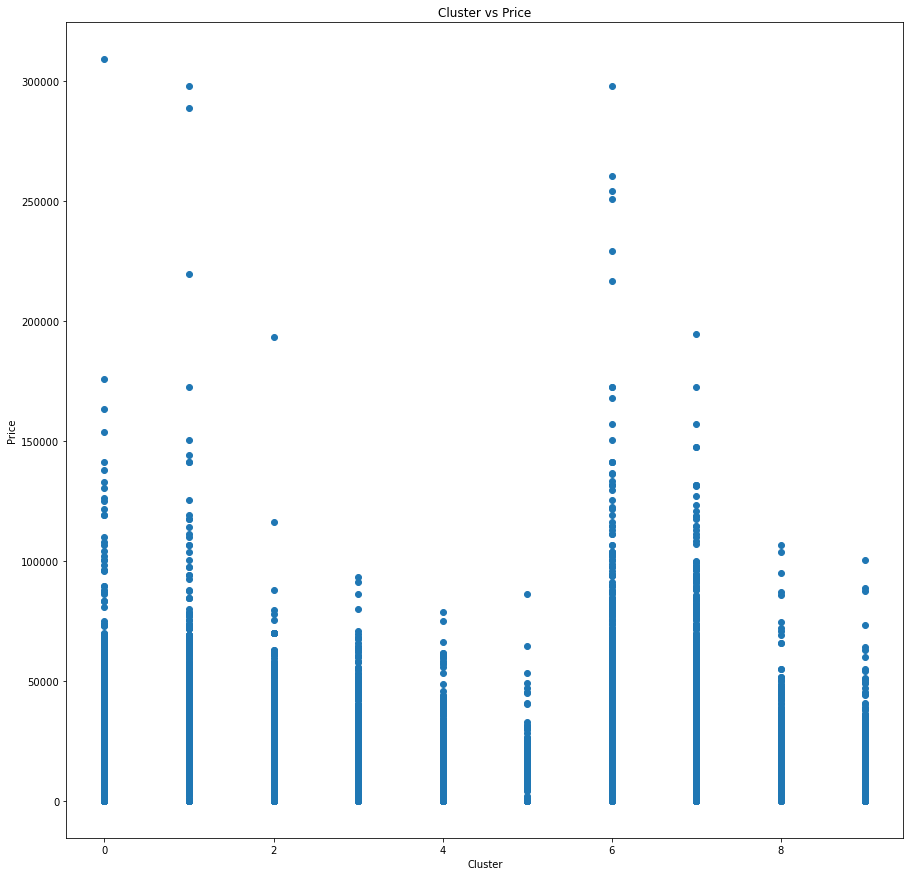

In [28]:
plt.scatter(clusters_3, significant_vars_df["Price"])
plt.xlabel("Cluster")
plt.ylabel("Price")
plt.title("Cluster vs Price")
plt.show()

**Numerical Predictor Transformations**

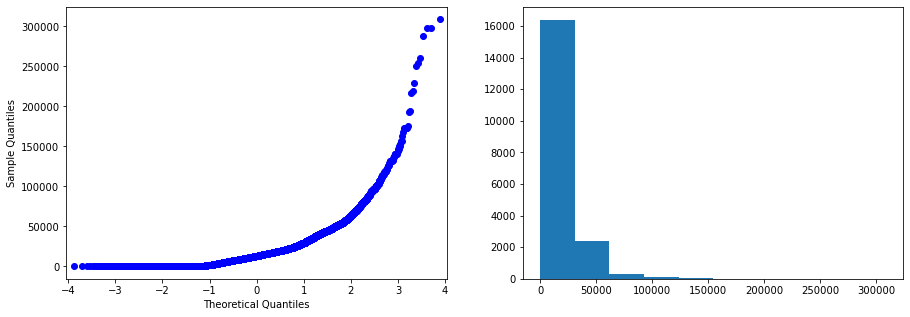

In [29]:
plt.rcParams["figure.figsize"] = (15, 5)
fig, ax = plt.subplots(1,2)
sm.qqplot(significant_vars_df["Price"], ax=ax[0])
ax[1] = plt.hist(significant_vars_df["Price"])
plt.show()

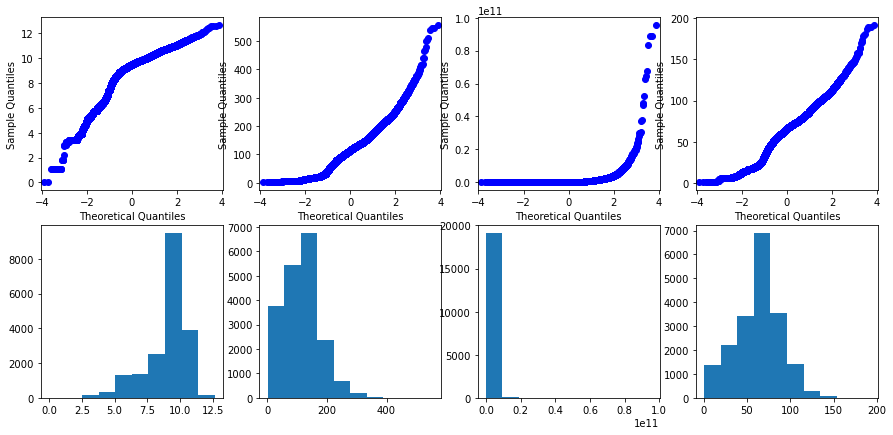

In [30]:
plt.rcParams["figure.figsize"] = (15, 7)
fig, ax = plt.subplots(2,4)
sm.qqplot(np.log(significant_vars_df["Price"]), ax = ax[0][0])
sm.qqplot(np.sqrt(significant_vars_df["Price"]), ax = ax[0][1])
sm.qqplot(np.square(significant_vars_df["Price"]), ax = ax[0][2])

price_norm, _ = stats.yeojohnson(significant_vars_df["Price"])

sm.qqplot(price_norm, ax = ax[0][3])

ax[1][0].hist(np.log(significant_vars_df["Price"]))
ax[1][1].hist(np.sqrt(significant_vars_df["Price"]))
ax[1][2].hist(np.square(significant_vars_df["Price"]))
ax[1][3].hist(price_norm)


plt.show()

From the above plots, it appears as if the yeo-johnson transform is the most effective at normalizing our data. For standardization, we will try applying this transform our average price column

In [31]:
trans_cars = significant_vars_df.copy(deep=True)
trans_cars["Price"] = price_norm
trans_cars["Average_price_MMC"] = stats.yeojohnson(significant_vars_df["Average_price_MMC"])[0]
trans_cars["Levy_Numeric"] = stats.yeojohnson(significant_vars_df["Levy_Numeric"])[0]
trans_cars["Dist_from_med_PY"] = stats.yeojohnson(significant_vars_df["Dist_from_med_PY"])[0]
trans_cars["Engine_vol_numeric"] = stats.yeojohnson(significant_vars_df["Engine_vol_numeric"])[0]

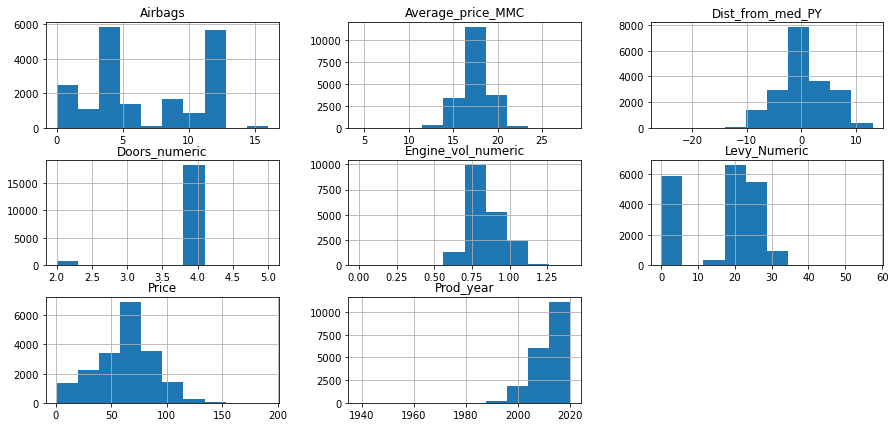

In [32]:
trans_cars.select_dtypes(include=[np.int64, np.float64]).hist()
plt.show()

## Fitting models with transformed Data

We have quite a few transformations to test so lets start with clusters to see if they are valuable or not. We will try using all three of our cluster atteempts to see which provides the most valuable results if any. We will do so against our untransformed quantitative data. 

First we will start by creating a dataframe that contains our cluster labels instead of the catagorical variables we are trying to replace. Since these are also labels, we will have to create dummy variables for each cluster. 

In [33]:
# Create copies of our dataframe for variable substitution
clust_1_df = significant_vars_df.copy(deep=True)
clust_2_df = significant_vars_df.copy(deep=True)
clust_3_df = significant_vars_df.copy(deep=True)

# Drop the columns we have clustered from each df
clust_1_df.drop(to_cluster_1, axis=1, inplace=True)
clust_2_df.drop(to_cluster_2, axis=1, inplace=True)
clust_3_df.drop(to_cluster_3, axis=1, inplace=True)

# Cast the integer labels of each cluster to a string so we can create dummy vars
clust_1_df["Cluster"] = [str(x) for x in clusters_1]
clust_2_df["Cluster"] = [str(x) for x in clusters_2]
clust_3_df["Cluster"] = [str(x) for x in clusters_3]

# Get dummy variables for each cluster df
clust_1_df = pd.get_dummies(clust_1_df)
clust_2_df = pd.get_dummies(clust_2_df)
clust_3_df = pd.get_dummies(clust_3_df)

# Reorder columns to put price at the front
clust_1_df = clust_1_df[["Price"] + [c for c in clust_1_df if c not in "Price"]]
clust_2_df = clust_2_df[["Price"] + [c for c in clust_2_df if c not in "Price"]]
clust_3_df = clust_3_df[["Price"] + [c for c in clust_3_df if c not in "Price"]]

print(f"New Dataframe Shapes\n")
print(f"{clust_1_df.shape}\n{clust_2_df.shape}\n{clust_3_df.shape}")

New Dataframe Shapes

(19234, 24)
(19234, 25)
(19234, 21)


Below we will fit the model for our first cluster attempt

In [34]:
#clust_1_df = clust_1_df.rename({"Cluster_2": "Cluster_two"})
regressors = " + ".join(clust_1_df.columns[1:])
equation = f"Price ~ {regressors}"
clust1_model_res = smf.ols(formula=equation,
                data=clust_1_df).fit()
  
# model summary
clust1_model_summary = clust1_model_res.summary()
print(clust1_model_summary)

                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.527
Model:                            OLS   Adj. R-squared:                  0.527
Method:                 Least Squares   F-statistic:                     1021.
Date:                Thu, 20 Oct 2022   Prob (F-statistic):               0.00
Time:                        17:10:09   Log-Likelihood:            -2.0884e+05
No. Observations:               19234   AIC:                         4.177e+05
Df Residuals:                   19212   BIC:                         4.179e+05
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

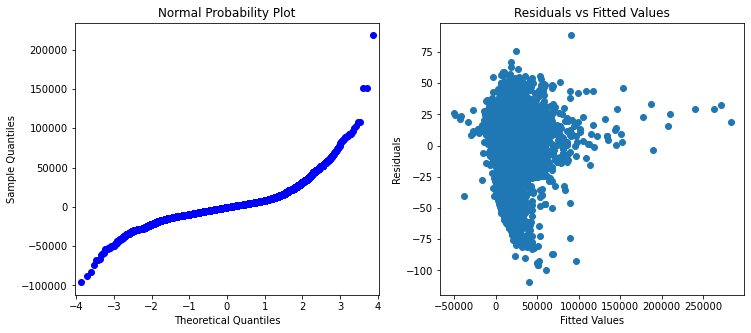

In [72]:
plt.rcParams["figure.figsize"] = (12,5)

fig, ax = plt.subplots(1,2)

sm.qqplot(clust1_model_res.resid, ax=ax[0])
ax[0].set_title("Normal Probability Plot")


ax[1].scatter(clust1_model_res.fittedvalues, trans_cars_model_res.resid)
ax[1].set_xlabel("Fitted Values")
ax[1].set_ylabel("Residuals")
ax[1].set_title("Residuals vs Fitted Values")

plt.show()

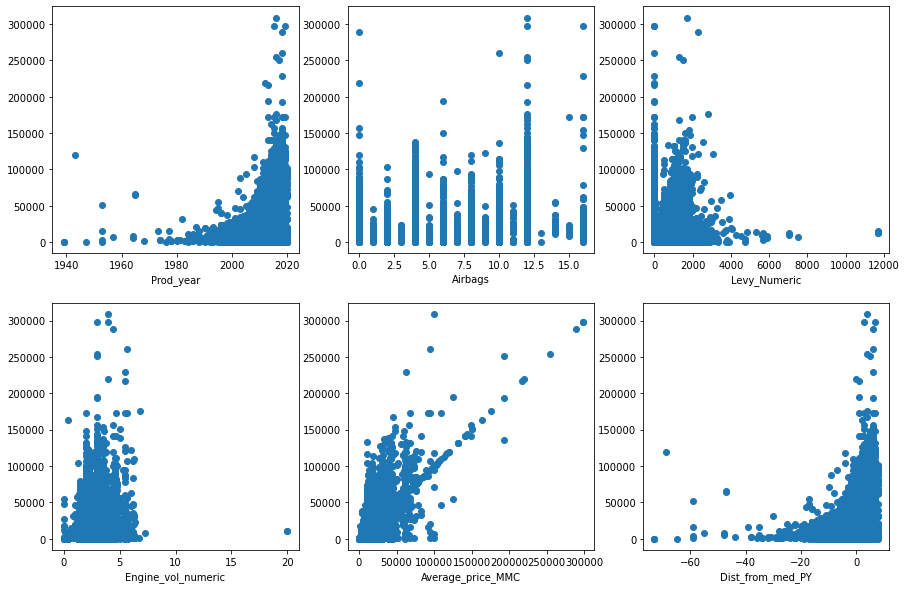

<Figure size 1080x576 with 0 Axes>

In [73]:
scatter_numerics_vs_price(clust_1_df, figsize=(15, 10))

Next we will fit a model for our second clustering attempt

In [35]:
regressors = " + ".join(clust_2_df.columns[1:])
equation = f"Price ~ {regressors}"
clust2_model_res = smf.ols(formula=equation,
                data=clust_2_df).fit()
  
# model summary
clust2_model_summary = clust2_model_res.summary()
print(clust2_model_summary)

                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.522
Model:                            OLS   Adj. R-squared:                  0.522
Method:                 Least Squares   F-statistic:                     955.4
Date:                Thu, 20 Oct 2022   Prob (F-statistic):               0.00
Time:                        17:10:15   Log-Likelihood:            -2.0894e+05
No. Observations:               19234   AIC:                         4.179e+05
Df Residuals:                   19211   BIC:                         4.181e+05
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

Finally we will fit with our third clustering attempt

In [36]:
regressors = " + ".join(clust_3_df.columns[1:])
equation = f"Price ~ {regressors}"
clust3_model_res = smf.ols(formula=equation,
                data=clust_3_df).fit()
  
# model summary
clust3_model_summary = clust3_model_res.summary()
print(clust3_model_summary)

                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.520
Model:                            OLS   Adj. R-squared:                  0.519
Method:                 Least Squares   F-statistic:                     1155.
Date:                Thu, 20 Oct 2022   Prob (F-statistic):               0.00
Time:                        17:10:21   Log-Likelihood:            -2.0899e+05
No. Observations:               19234   AIC:                         4.180e+05
Df Residuals:                   19215   BIC:                         4.182e+05
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

We can see that our first clustering attempt was the most succesful. 

Next we will fit a model with our transformed quantitative data. 

In [37]:
trans_cars = trans_cars[["Price"] + [c for c in trans_cars if c not in "Price"]]
regressors = " + ".join(trans_cars.columns[1:])
equation = f"Price ~ {regressors}"
trans_cars_model_res = smf.ols(formula=equation,
                data=trans_cars).fit()
  
# model summary
print(trans_cars_model_res.summary())

                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.399
Model:                            OLS   Adj. R-squared:                  0.398
Method:                 Least Squares   F-statistic:                     439.8
Date:                Thu, 20 Oct 2022   Prob (F-statistic):               0.00
Time:                        17:10:28   Log-Likelihood:                -85104.
No. Observations:               19234   AIC:                         1.703e+05
Df Residuals:                   19204   BIC:                         1.705e+05
Df Model:                          29                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

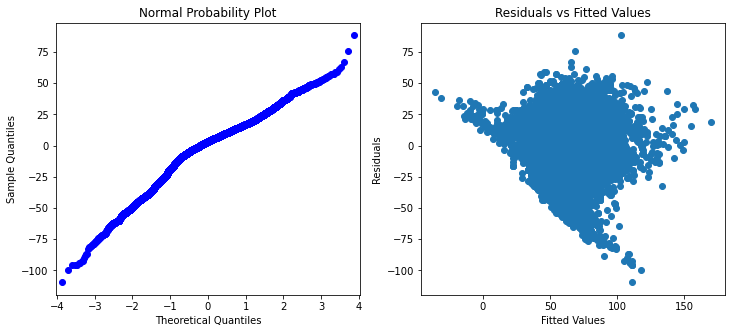

In [64]:
plt.rcParams["figure.figsize"] = (12,5)

fig, ax = plt.subplots(1,2)

sm.qqplot(trans_cars_model_res.resid, ax=ax[0])
ax[0].set_title("Normal Probability Plot")


ax[1].scatter(trans_cars_model_res.fittedvalues, trans_cars_model_res.resid)
ax[1].set_xlabel("Fitted Values")
ax[1].set_ylabel("Residuals")
ax[1].set_title("Residuals vs Fitted Values")

plt.show()

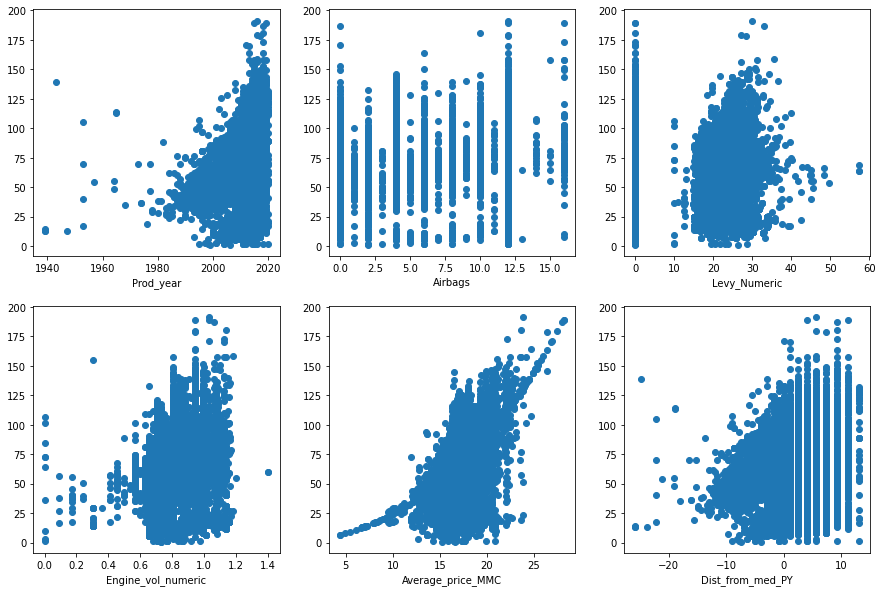

<Figure size 1080x576 with 0 Axes>

In [70]:
scatter_numerics_vs_price(trans_cars, figsize=(15, 10))

In [75]:
trans_cars_noprice = trans_cars.drop("Price", axis=1, inplace=False)
vif = pd.DataFrame()
vif["features"] = trans_cars_noprice.columns
vif["vif_Factor"] = [variance_inflation_factor(trans_cars_noprice.values, i) for i in range(trans_cars_noprice.shape[1])]
vif

,features,vif_Factor
0,Prod_year,303.823650
1,Airbags,4.351829
2,Levy_Numeric,5.547914
3,Leather_Interior_Numeric,6.018595
4,Wheel_Numeric,1.499650
5,Engine_vol_numeric,82.941884
6,Has_turbo,1.436733
7,Average_price_MMC,153.814876
8,Dist_from_med_PY,1.875530
9,Doors_numeric,154.884501


In [ ]:
sns.pairplot(trans_cars_processed.select_dtypes(include=[np.int64, np.float64]))

## Combining Transformed Data

We will replace catagorical variables with our most succesful clustering attempt and fit a model with our transformed quantitative data

In [77]:
combined_df = trans_cars.drop(to_cluster_1, axis=1, inplace=False)
combined_df["Cluster"] = [str(x) for x in clusters_1]
combined_df = pd.get_dummies(combined_df)
combined_df = combined_df[["Price"] + [c for c in combined_df if c not in "Price"]]
combined_df

,Price,Prod_year,Airbags,Levy_Numeric,Leather_Interior_Numeric,Wheel_Numeric,Engine_vol_numeric,Has_turbo,Average_price_MMC,Dist_from_med_PY,...,Color_Red,Color_Silver,Cluster_0,Cluster_1,Cluster_2,Cluster_3,Cluster_4,Cluster_5,Cluster_6,Cluster_7
0,66.097786,2010,12,27.864744,1,0,0.992698,0,16.495571,-1.630649,...,0,1,1,0,0,0,0,0,0,0
1,71.305868,2011,8,24.912646,0,0,0.942975,0,15.929827,-0.884565,...,0,0,0,0,0,0,0,0,0,1
2,56.513501,2006,2,0.000000,0,1,0.656310,0,16.606001,-4.038682,...,0,0,0,0,0,0,0,0,1,0
3,41.940835,2011,0,23.481996,1,0,0.882209,0,15.733085,-0.884565,...,0,0,1,0,0,0,0,0,0,0
4,63.246102,2014,4,18.498101,1,0,0.656310,0,16.606001,2.477343,...,0,1,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19229,56.513501,1999,5,0.000000,1,0,0.805766,1,15.522551,-7.342428,...,0,1,0,1,0,0,0,0,0,0
19230,69.895748,2011,8,23.176943,1,0,0.868366,0,17.381968,-0.884565,...,1,0,0,0,1,0,0,0,0,0
19231,83.211319,2010,4,23.226666,1,0,0.805766,0,19.666091,-1.630649,...,0,0,1,0,0,0,0,0,0,0
19232,48.107545,2007,4,27.068442,1,0,0.805766,0,18.005814,-3.491977,...,0,0,1,0,0,0,0,0,0,0


In [78]:
regressors = " + ".join(combined_df.columns[1:])
equation = f"Price ~ {regressors}"
combined_model_res = smf.ols(formula=equation,
                data=combined_df).fit()
  
# model summary
print(combined_model_res.summary())

                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.396
Model:                            OLS   Adj. R-squared:                  0.395
Method:                 Least Squares   F-statistic:                     572.5
Date:                Thu, 20 Oct 2022   Prob (F-statistic):               0.00
Time:                        18:45:37   Log-Likelihood:                -85154.
No. Observations:               19234   AIC:                         1.704e+05
Df Residuals:                   19211   BIC:                         1.705e+05
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

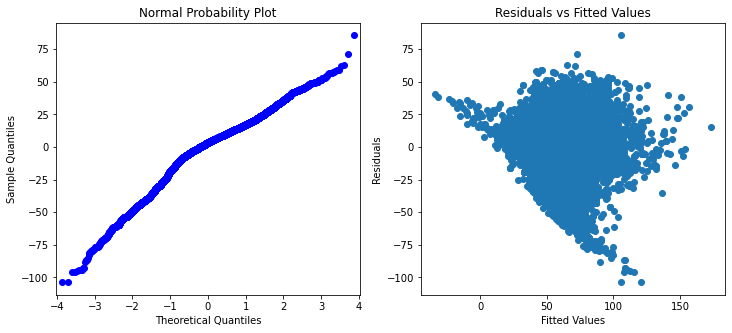

In [79]:
plt.rcParams["figure.figsize"] = (12,5)

fig, ax = plt.subplots(1,2)

sm.qqplot(combined_model_res.resid, ax=ax[0])
ax[0].set_title("Normal Probability Plot")


ax[1].scatter(combined_model_res.fittedvalues, combined_model_res.resid)
ax[1].set_xlabel("Fitted Values")
ax[1].set_ylabel("Residuals")
ax[1].set_title("Residuals vs Fitted Values")

plt.show()

In [80]:
combined_df_noprice = combined_df.drop("Price", axis=1, inplace=False)
vif = pd.DataFrame()
vif["features"] = combined_df_noprice.columns
vif["vif_Factor"] = [variance_inflation_factor(combined_df_noprice.values, i) for i in range(combined_df_noprice.shape[1])]
vif

,features,vif_Factor
0,Prod_year,9.406645
1,Airbags,1.303929
2,Levy_Numeric,1.823190
3,Leather_Interior_Numeric,1.547089
4,Wheel_Numeric,1.292418
5,Engine_vol_numeric,1.545136
6,Has_turbo,1.188420
7,Average_price_MMC,1.484289
8,Dist_from_med_PY,8.348203
9,Doors_numeric,1.132835


In [82]:
significant_vars_2 = []

# Iterate through the table and find all significant predictors
for i in range(2, len(combined_model_res.summary().tables[1])):
    if float(str(combined_model_res.summary().tables[1][i][4])) < 0.05:
        significant_vars_2 += [str(combined_model_res.summary().tables[1][i][0])]
        
significant_vars_2

['Prod_year',
 'Airbags',
 'Levy_Numeric',
 'Leather_Interior_Numeric',
 'Wheel_Numeric',
 'Engine_vol_numeric',
 'Has_turbo',
 'Average_price_MMC',
 'Dist_from_med_PY',
 'Color_Grey',
 'Color_Purple',
 'Color_Red',
 'Color_Silver',
 'Cluster_0',
 'Cluster_1',
 'Cluster_2',
 'Cluster_3',
 'Cluster_4',
 'Cluster_5',
 'Cluster_6',
 'Cluster_7']

In [85]:
significant_vars_2 = ["Price"] + significant_vars_2 # Add price back into the list
significant_vars_df_2 = combined_df.copy(deep=True)[significant_vars_2]   # Create a dataframe with only significant predictors
significant_vars_df_2

,Price,Prod_year,Airbags,Levy_Numeric,Leather_Interior_Numeric,Wheel_Numeric,Engine_vol_numeric,Has_turbo,Average_price_MMC,Dist_from_med_PY,...,Color_Red,Color_Silver,Cluster_0,Cluster_1,Cluster_2,Cluster_3,Cluster_4,Cluster_5,Cluster_6,Cluster_7
0,66.097786,2010,12,27.864744,1,0,0.992698,0,16.495571,-1.630649,...,0,1,1,0,0,0,0,0,0,0
1,71.305868,2011,8,24.912646,0,0,0.942975,0,15.929827,-0.884565,...,0,0,0,0,0,0,0,0,0,1
2,56.513501,2006,2,0.000000,0,1,0.656310,0,16.606001,-4.038682,...,0,0,0,0,0,0,0,0,1,0
3,41.940835,2011,0,23.481996,1,0,0.882209,0,15.733085,-0.884565,...,0,0,1,0,0,0,0,0,0,0
4,63.246102,2014,4,18.498101,1,0,0.656310,0,16.606001,2.477343,...,0,1,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19229,56.513501,1999,5,0.000000,1,0,0.805766,1,15.522551,-7.342428,...,0,1,0,1,0,0,0,0,0,0
19230,69.895748,2011,8,23.176943,1,0,0.868366,0,17.381968,-0.884565,...,1,0,0,0,1,0,0,0,0,0
19231,83.211319,2010,4,23.226666,1,0,0.805766,0,19.666091,-1.630649,...,0,0,1,0,0,0,0,0,0,0
19232,48.107545,2007,4,27.068442,1,0,0.805766,0,18.005814,-3.491977,...,0,0,1,0,0,0,0,0,0,0


In [87]:
regressors = " + ".join(significant_vars_df_2.columns[1:])
equation = f"Price ~ {regressors}"
sv2_res = smf.ols(formula=equation,
                data=significant_vars_df_2).fit()
  
# model summary
print(sv2_res.summary())

                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.396
Model:                            OLS   Adj. R-squared:                  0.395
Method:                 Least Squares   F-statistic:                     629.4
Date:                Thu, 20 Oct 2022   Prob (F-statistic):               0.00
Time:                        20:45:20   Log-Likelihood:                -85156.
No. Observations:               19234   AIC:                         1.704e+05
Df Residuals:                   19213   BIC:                         1.705e+05
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

In [ ]:
# correlation matrix title
print("\033[1m"+'Car Price Prediction Data: Correlation Matrix'+"\033[1m")
# assign correlation function to new variable
corr = trans_cars.corr()
matrix = np.triu(corr) # for triangular matrix
plt.figure(figsize=(20,20))
# parse corr variable intro triangular matrix
sns.heatmap(trans_cars.corr(method='pearson'),
            annot=True, linewidths=.5,
            cmap="coolwarm", mask=matrix,
            square = True,
            cbar_kws={'label': 'Correlation Index'})
plt.show()